### Goal:
Evaluate the performance of the CPSign model (CVAP)

In [39]:
from pip._internal import main as pip

try:
    import pandas as pd
except ImportError:
    pip(['install', 'pandas'])
    import pandas as pd
    
try:
    import sklearn
    from sklearn import metrics
except ImportError:
    pip(['install', 'sklearn'])
    import sklearn
    from sklearn import metrics
    
try:
    import matplotlib.pyplot as plt
except ImportError:
    pip(['install', 'matplotlib'])
    import matplotlib.pyplot as plt

#### Read the provided dataset and curate

In [40]:
df = pd.read_csv('predictions_CPSign - from Staffan.csv', sep='\t')

# select first 4 columns and rename
df = df.iloc[:, 0:4]
df.columns = ['SMILES', 'True', 'Probability_N', 'Probability_P']

df.head()

,SMILES,True,Probability_N,Probability_P
0,O=C(N1CCCC[C@H]1CN1CCCC1)Cc1ccc(cc1)C(F)(F)F,penetrating,0.142,0.858
1,CCCO,penetrating,0.140,0.860
2,NCCCNCCSP(=O)(O)O,non-penetrating,0.109,0.891
3,CNC[C@@H](c1ccc(c(c1)O)O)O,non-penetrating,0.569,0.431
4,CC[C@@H](c1ccccc1)NC(=O)c1c(C)c(nc2c1cccc2)c1c...,penetrating,0.736,0.264


#### Calculate predicted class

In [41]:
def classify(prob_p, prob_n):
    if prob_p > prob_n:
        return 'penetrating'
    else:
        return 'non-penetrating'

In [42]:
df['Predicted'] = df.apply(lambda x: classify(x['Probability_P'], x['Probability_N']), axis=1)

dfCP = df.copy()
dfCP = dfCP[['SMILES', 'True', 'Predicted', 'Probability_P', 'Probability_N']]
dfCP.to_csv('predictions_CPSign.csv', index=False)

#### Evaluate model performance
- confusion matrix
- ROC, AUC

In [43]:
# confusion matrix
conf = pd.crosstab(dfCP['True'], dfCP['Predicted'])
conf

Predicted,non-penetrating,penetrating
True,,
non-penetrating,82,57
penetrating,35,241


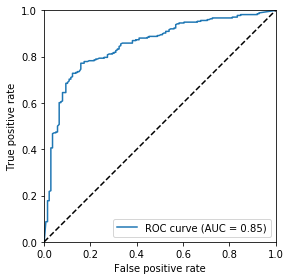

In [44]:
# ROC plot
df = dfCP.copy()

df = df.dropna(axis=0, how='any').drop_duplicates()

df['Probability_diff'] = (df['Probability_P'] - df['Probability_N']) # / 2. + 0.5
df['True'] = df['True'].replace({'penetrating': 1, 'non-penetrating': 0})

# compute ROC
fpr, tpr, thresholds = metrics.roc_curve(df['True'], df['Probability_diff'], pos_label=1)

# compute AUC
auc = metrics.auc(fpr, tpr)

# prepare the plot
fig, ax = plt.subplots(1, 1)

ax.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
ax.plot([0,1], [0,1], label='', color='black', linestyle='--')
ax.legend(loc="lower right")
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_aspect('equal')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

fig.tight_layout()

plt.show()